In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
homepath = os.path.join(os.path.abspath(''), "experiment_results")
stat_results = os.path.join(homepath, "stat") 
lookup_results = os.path.join(homepath, "lookup") 
modify_results = os.path.join(homepath, "modify") 
enron_stat, github_stat = os.path.join(stat_results, "enron"), os.path.join(stat_results, "github")
enron_lookup, github_lookup = os.path.join(lookup_results, "enron"), os.path.join(lookup_results, "github")
enron_modify, github_modify = os.path.join(modify_results, "enron"), os.path.join(modify_results, "github")

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

GRAPH_COLOR = cm.YlGnBu
color_dict = {
    "Excel": GRAPH_COLOR(90),
    "TACO": GRAPH_COLOR(250),
    "NoComp": GRAPH_COLOR(190),
    "Antifreeze": GRAPH_COLOR(90),
    "Maximum Dependents": GRAPH_COLOR(190),
    "Longest Path": GRAPH_COLOR(250),
}
style_dict = {
    "TACO": "--",
    "NoComp": "-",
    "Maximum Dependents":"-.",
    "Longest Path": "-"
}
rcParams['font.family'] = 'Serif'
legend_size = 50
label_size = 60
tick_size = 60
fig_width = 16
fig_height = 10

In [4]:
def get_pdf_df(df, column_name, is_log=True):
    ls = [x if x >= 1 else 1 for x in df[column_name]]
    length = len(ls)
    if is_log:
        data = pd.Series(np.log10(ls))
    else:
        data = pd.Series(ls)
    freq = data.value_counts().sort_index(axis=0, ascending=True).reset_index() 
    freq[0] = freq[0] / length
    freq['cumsum'] = np.cumsum(freq[0])
    return freq

In [5]:
def convert_upper_str(num):
    upper_ls = '⁰¹²³⁴⁵⁶⁷⁸⁹'
    index = int(np.log10(num))
    return str(10) + upper_ls[int(np.log10(num))]

In [6]:
def plot_percentile(df_ls, 
                    legend_ls, 
                    xlabel, 
                    ylabel, 
                    x_tick_min,
                    x_tick_max,
                    x_tick_num,
                    fig_size=(fig_width, fig_height),
                    legend_size=legend_size,
                    tick_size=tick_size,
                    label_size=label_size,
                    color_dict=color_dict,
                    save_path=None):
    assert len(df_ls) == len(legend_ls)
    fig, ax = plt.subplots(figsize=fig_size)
    for i in range(len(df_ls)):
        df, label = df_ls[i], legend_ls[i]
        ax.plot(df['index'], df['cumsum'], label=label, color=color_dict[label], linestyle=style_dict[label], linewidth=7.)
    
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    x_ticks = np.arange(x_tick_min, x_tick_max+0.1, step=(x_tick_max - x_tick_min)/x_tick_num).astype(int)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([convert_upper_str(10**x) for x in x_ticks], fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    ax.legend(fontsize=legend_size, loc="lower right")
    ax.grid(True)
    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [7]:
def plot_bar_chart(df,
                   file_list,
                   label_column_dict,
                   xlabel,
                   ylabel,
                   y_tick_min,
                   y_tick_max,
                   y_tick_num,
                   bar_width=0.25,
                   fig_size=(fig_width, fig_height),
                   legend_size=legend_size,
                   tick_size=tick_size,
                   label_size=label_size,
                   color_dict=color_dict,
                   is_ceil=True,
                   is_seperate=True,
                   save_path=None
                  ):
    
    x_ticks = np.arange(len(file_list))
    x_ticks_min, x_ticks_max = 100, -100
    bar_labels = list(label_column_dict.keys())
    num_bars = len(bar_labels)
    fig, ax = plt.subplots(figsize=fig_size)
    for idx, bar_label in enumerate(bar_labels):
        x = x_ticks - ((num_bars - 1) * bar_width)/2 + idx * bar_width
        x_ticks_min = min(x.min(), x_ticks_min)
        x_ticks_max = max(x.max(), x_ticks_max)
        arr = df[label_column_dict[bar_label]].values
        arr = np.array([x if x >= 1.0 else 1.0 for x in arr])
        rect = ax.bar(x_ticks - ((num_bars - 1) * bar_width)/2 + idx * bar_width,
                      np.log10(arr) + 0.5,
                      bar_width, label=bar_label,
                      color=color_dict[bar_label],
                      bottom=-0.5
                     )
    
    if is_ceil:
        plt.axhline(y=np.log10(5*60*1000), color="r", linewidth=5)
        plt.text(x_ticks_min+3.38, np.log10(5*60*1000)-0.08, "DNF", 
                 fontsize=48, weight='bold', verticalalignment="top", horizontalalignment="right", color="r")
    if is_seperate:
        plt.axvline(x=(x_ticks_min + x_ticks_max) / 2.0, ymax=np.log10(5*60*1000)-0.1, color='g', ls='--', linewidth=3.0)
    
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    y_ticks = np.arange(y_tick_min, y_tick_max+0.1, step=(y_tick_max - y_tick_min)/y_tick_num).astype(int)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([convert_upper_str(10**x) for x in y_ticks], fontsize=tick_size)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(file_list, fontsize=tick_size, rotation=-45)
    ax.legend(fontsize=legend_size, loc="upper right", ncol=num_bars)
    plt.xlim(x_ticks_min-bar_width/2.0, x_ticks_max+bar_width/2.0)
    plt.ylim(-0.4, np.log10(5*60*1000) + 0.01)
    plt.grid(axis='y')
    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# 1. Compressed Formula Graph Sizes

In [8]:
def graph_compare_preprocess(df, is_inrow=False):
    df['Edges_Diff'] = df['numEdges'] - df['numCompEdges']
    df['Edges_Prec'] = df['numCompEdges'] / df['numEdges']
    if not is_inrow:
        pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain']
        for pattern in pattern_type:
            if pattern != 'RRGap':
                df[pattern + "_Diff"] = df[pattern + "_NoComp"] - df[pattern + "_Comp"]
            else:
                df[pattern + "_Diff"] = 0
                gaps = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven']
                for gap in gaps:
                    pattern_name = pattern + gap
                    df[pattern + "_Diff"] += (df[pattern_name + "_NoComp"] - df[pattern_name + "_Comp"])
    return df

In [9]:
df_enron_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_taco_dollar_stat.csv"))
df_github_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_taco_dollar_stat.csv"))
df_enron_inrow_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_taco_inrow_stat.csv"), True)
df_github_inrow_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_taco_inrow_stat.csv"), True)

## 1.1 Formula graph sizes after TACO compression (low is better)

In [10]:
df_graph_enron_compare = pd.DataFrame()
df_graph_enron_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_enron_compare['Vertices'] = [df_enron_stat['numVertices'].sum(), df_enron_inrow_stat['numCompVertices'].sum(), df_enron_stat['numCompVertices'].sum()]
df_graph_enron_compare['Edges'] = [df_enron_stat['numEdges'].sum(), df_enron_inrow_stat['numCompEdges'].sum(), df_enron_stat['numCompEdges'].sum()]
df_graph_enron_compare['Vertices_Percentage'] = df_graph_enron_compare['Vertices'] / df_graph_enron_compare['Vertices'].max()
df_graph_enron_compare['Edges_Percentage'] = df_graph_enron_compare['Edges'] / df_graph_enron_compare['Edges'].max()
df_graph_enron_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,18645760,23733499,1.000000,1.000000
TACO-Inrow,7680116,12521118,0.411896,0.527572
TACO,1173102,1183680,0.062915,0.049874


In [11]:
df_graph_github_compare = pd.DataFrame()
df_graph_github_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_github_compare['Vertices'] = [df_github_stat['numVertices'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompVertices'].sum()]
df_graph_github_compare['Edges'] = [df_github_stat['numEdges'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompEdges'].sum()]
df_graph_github_compare['Vertices_Percentage'] = df_graph_github_compare['Vertices'] / df_graph_github_compare['Vertices'].max()
df_graph_github_compare['Edges_Percentage'] = df_graph_github_compare['Edges'] / df_graph_github_compare['Edges'].max()
df_graph_github_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,165771046,179788109,1.000000,1.000000
TACO-Inrow,55202083,55202083,0.333002,0.307040
TACO,4192821,3493528,0.025293,0.019431


## 1.2 The number of edges reduced by TACO (high is better)

In [12]:
df_enron_edge_reduce = pd.DataFrame()
df_enron_edge_reduce['TACO-Inrow'] = df_enron_inrow_stat['Edges_Diff']
df_enron_edge_reduce['TACO'] = df_enron_stat['Edges_Diff']
df_enron_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,142396.0,18196.0,12488.5,18876.062290
TACO,700155.0,37285.5,18379.5,37962.658249


In [13]:
df_github_edge_reduce = pd.DataFrame()
df_github_edge_reduce['TACO-Inrow'] = df_github_inrow_stat['Edges_Diff']
df_github_edge_reduce['TACO'] = df_github_stat['Edges_Diff']
df_github_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,1693698.0,42728.0,19703.5,45303.024532
TACO,3139011.0,75552.5,31607.5,78632.730152


## 1.3 Remaining edge fractions after compression (low is better)

In [14]:
df_enron_edge_prec = pd.DataFrame()
df_enron_edge_prec['TACO-Inrow'] = df_enron_inrow_stat['Edges_Prec']
df_enron_edge_prec['TACO'] = df_enron_stat['Edges_Prec']
df_enron_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.000042,0.063182,0.398134,0.422732
TACO,0.000042,0.004712,0.019261,0.073657


In [15]:
df_github_edge_prec = pd.DataFrame()
df_github_edge_prec['TACO-Inrow'] = df_github_inrow_stat['Edges_Prec']
df_github_edge_prec['TACO'] = df_github_stat['Edges_Prec']
df_github_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.000005,0.000994,0.174480,0.364801
TACO,0.000005,0.000317,0.001901,0.034441


## 1.4 Number of edges reduced by each pattern (high is better)

In [16]:
df_enron_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain']
for pattern in pattern_type:
    df_enron_pattern_reduce[pattern] = df_enron_stat[pattern + "_Diff"]
df_enron_pattern_stat = pd.DataFrame()
df_enron_pattern_stat.index = df_enron_pattern_reduce.T.index
df_enron_pattern_stat['Sum'] = df_enron_pattern_reduce.sum()
df_enron_pattern_stat['Max'] = df_enron_pattern_reduce.max()
df_enron_pattern_stat

,Sum,Max
RR,17412246,525026
RF,1880,1413
FR,150845,13815
FF,3844351,174948
RR-Chain,566348,24596


In [17]:
df_github_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain']
for pattern in pattern_type:
    df_github_pattern_reduce[pattern] = df_github_stat[pattern + "_Diff"]
df_github_pattern_stat = pd.DataFrame()
df_github_pattern_stat.index = df_github_pattern_reduce.T.index
df_github_pattern_stat['Sum'] = df_github_pattern_reduce.sum()
df_github_pattern_stat['Max'] = df_github_pattern_reduce.max()
df_github_pattern_stat

,Sum,Max
RR,141876182,2094936
RF,13361,9999
FR,178609,39008
FF,24784621,1043702
RR-Chain,5867728,399996


# 2. Building Graphs

In [18]:
column_list = ['fileName', 'GraphBuildTime']
df_enron_taco_max = pd.read_csv(f"{enron_lookup}/enron_max_taco_10k_1.csv")[column_list]
df_enron_taco_long = pd.read_csv(f"{enron_lookup}/enron_long_taco_10k_1.csv")[column_list]
df_enron_nocomp_max = pd.read_csv(f"{enron_lookup}/enron_max_nocomp_10k_1.csv")[column_list]
df_enron_nocomp_long = pd.read_csv(f"{enron_lookup}/enron_long_nocomp_10k_1.csv")[column_list]
df_github_taco_max =  pd.read_csv(f"{github_lookup}/github_max_taco_10k_1.csv")[column_list]
df_github_taco_long = pd.read_csv(f"{github_lookup}/github_long_taco_10k_1.csv")[column_list]
df_github_nocomp_max = pd.read_csv(f"{github_lookup}/github_max_nocomp_10k_1.csv")[column_list]
df_github_nocomp_long = pd.read_csv(f"{github_lookup}/github_long_nocomp_10k_1.csv")[column_list]

In [19]:
df_enron_taco = pd.merge(df_enron_taco_max, df_enron_taco_long, how="inner", on=["fileName"])
df_enron_nocomp = pd.merge(df_enron_nocomp_max, df_enron_nocomp_long, how="inner", on=["fileName"])
df_enron_taco['TACO_GraphBuildTime'] = (df_enron_taco['GraphBuildTime_x'] + df_enron_taco['GraphBuildTime_y']) / 2.
df_enron_nocomp['NoComp_GraphBuildTime'] = (df_enron_nocomp['GraphBuildTime_x'] + df_enron_nocomp['GraphBuildTime_y']) / 2.

In [20]:
enron_graph_result = pd.merge(df_enron_taco, df_enron_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [21]:
freq_enron_taco = get_pdf_df(enron_graph_result, 'TACO_GraphBuildTime')
freq_enron_nocomp = get_pdf_df(enron_graph_result, 'NoComp_GraphBuildTime')

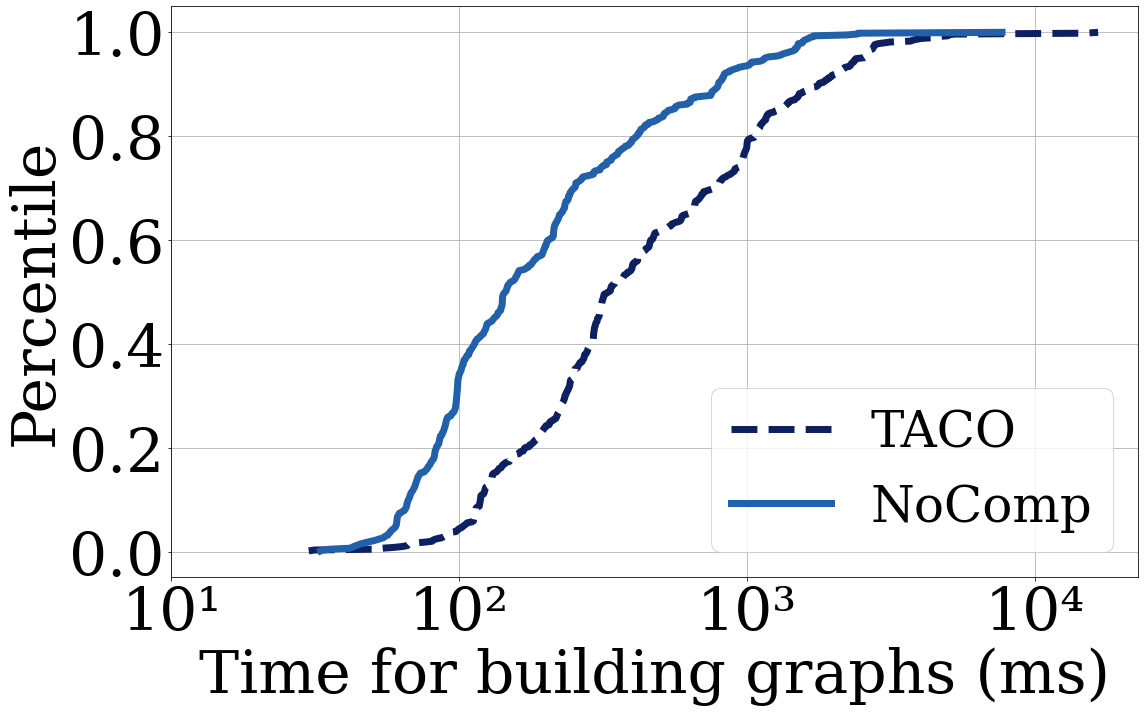

In [22]:
plot_percentile([freq_enron_taco, freq_enron_nocomp], 
                ["TACO", "NoComp"],
                xlabel="Time for building graphs (ms)",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3,
               )

In [23]:
df_github_taco = pd.merge(df_github_taco_max, df_github_taco_long, how="inner", on=["fileName"])
df_github_nocomp = pd.merge(df_github_nocomp_max, df_github_nocomp_long, how="inner", on=["fileName"])
df_github_taco['TACO_GraphBuildTime'] = (df_github_taco['GraphBuildTime_x'] + df_github_taco['GraphBuildTime_y']) / 2.
df_github_nocomp['NoComp_GraphBuildTime'] = (df_github_nocomp['GraphBuildTime_x'] + df_github_nocomp['GraphBuildTime_y']) / 2.

In [24]:
github_graph_result = pd.merge(df_github_taco, df_github_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [25]:
freq_github_taco = get_pdf_df(github_graph_result, 'TACO_GraphBuildTime')
freq_github_nocomp = get_pdf_df(github_graph_result, 'NoComp_GraphBuildTime')

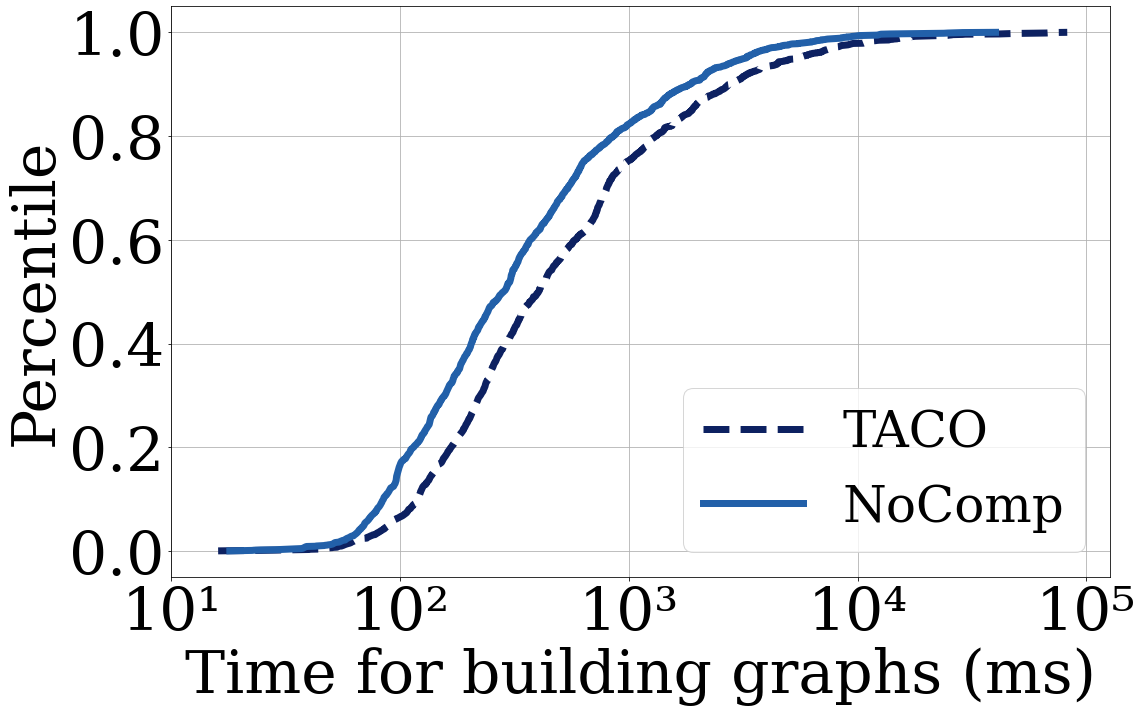

In [26]:
plot_percentile([freq_github_taco, freq_github_nocomp], 
                ["TACO", "NoComp"],
                xlabel="Time for building graphs (ms)",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

# 3. Returning Control to Users

In [27]:
def rename_columns(df, is_long=False):
    rename_map = {
        "TACOLookupSize": "taco_size",
        "TACOLookupTime": "taco_time",
        "TACOPostProcessedLookupSize": "taco_post_size",
        "TACOPostProcessedLookupTime": "taco_post_time",
        "NoCompLookupSize": "nocomp_size",
        "NoCompLookupTime": "nocomp_time",
        "NoCompPostProcessedLookupSize": "nocomp_post_size",
        "NoCompPostProcessedLookupTime": "nocomp_post_time",
    }
    
    if is_long:
        for key in rename_map:
            rename_map[key] = "long_" + rename_map[key]
    else:
        for key in rename_map:
            rename_map[key] = "max_" + rename_map[key]
            
    df = df.rename(columns=rename_map)
    if "GraphBuildTime" in list(df.columns):
        df = df.drop(['GraphBuildTime'], axis=1)
    
    remain_cols = [x for x in list(df.columns) if "post" not in x]
    return df[remain_cols]

In [28]:
def read_and_average_files(dir_path, fileName, is_long=False):
    df = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_1.csv"), is_long)
    df2 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_2.csv"), is_long)
    df3 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_3.csv"), is_long)
    column_list = list(df.columns)
    df_merged = pd.merge(df, df2, how="inner", on=[column_list[0], column_list[1]])
    df_merged = pd.merge(df_merged, df3, how="inner", on=[column_list[0], column_list[1]])
    list1, list2 = [], []
    for i in range(len(df_merged)):
        ls = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[2] in col_name]
        ls2 = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[3] in col_name]
        list1.append(np.mean(ls))
        list2.append(np.mean(ls2))
    df_merged[column_list[2]] = list1
    df_merged[column_list[3]] = list2
    return df_merged[column_list]

In [29]:
df_enron_taco_max = read_and_average_files(enron_lookup, "enron_max_taco_10k", False)
df_enron_taco_long = read_and_average_files(enron_lookup, "enron_long_taco_10k", True)
df_enron_nocomp_max = read_and_average_files(enron_lookup, "enron_max_nocomp_10k", False)
df_enron_nocomp_long = read_and_average_files(enron_lookup, "enron_long_nocomp_10k", True)
df_github_taco_max = read_and_average_files(github_lookup, "github_max_taco_10k", False)
df_github_taco_long = read_and_average_files(github_lookup, "github_long_taco_10k", True)
df_github_nocomp_max = read_and_average_files(github_lookup, "github_max_nocomp_10k", False)
df_github_nocomp_long = read_and_average_files(github_lookup, "github_long_nocomp_10k", True)

In [30]:
df_enron_max = pd.merge(df_enron_taco_max, df_enron_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_enron_long = pd.merge(df_enron_taco_long, df_enron_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [31]:
df_enron_merged = pd.merge(df_enron_max, df_enron_long, how="inner", on=["fileName"])

In [32]:
df_github_max = pd.merge(df_github_taco_max, df_github_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_github_long = pd.merge(df_github_taco_long, df_github_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [33]:
df_github_merged = pd.merge(df_github_max, df_github_long, how="inner", on=["fileName"])

In [34]:
most_dep = []
most_time = []
most_nocomp_time = []
for i in range(len(df_enron_merged)):
    max_time, long_time = df_enron_merged.loc[i, 'max_taco_time'], df_enron_merged.loc[i, 'long_taco_time']
    max_nocomp_time, long_nocomp_time = df_enron_merged.loc[i, 'max_nocomp_time'], df_enron_merged.loc[i, 'long_nocomp_time']
    if max_time > long_time:
        most_dep.append("m")
        most_time.append(df_enron_merged.loc[i, 'max_taco_time'])
    else:
        most_dep.append("l")
        most_time.append(df_enron_merged.loc[i, 'long_taco_time'])
    if max_nocomp_time > long_nocomp_time:
        most_nocomp_time.append(max_nocomp_time)
    else:
        most_nocomp_time.append(long_nocomp_time)
df_enron_merged['most_dep'] = most_dep
df_enron_merged['most_time'] = most_time
df_enron_merged['most_nocomp_time'] = most_nocomp_time

In [35]:
most_dep = []
most_time = []
most_nocomp_time = []
for i in range(len(df_github_merged)):
    max_time, long_time = df_github_merged.loc[i, 'max_taco_time'], df_github_merged.loc[i, 'long_taco_time']
    max_nocomp_time, long_nocomp_time = df_github_merged.loc[i, 'max_nocomp_time'], df_github_merged.loc[i, 'long_nocomp_time']
    if max_time > long_time:
        most_dep.append("m")
        most_time.append(df_github_merged.loc[i, 'max_taco_time'])
    else:
        most_dep.append("l")
        most_time.append(df_github_merged.loc[i, 'long_taco_time'])
    if max_nocomp_time > long_nocomp_time:
        most_nocomp_time.append(max_nocomp_time)
    else:
        most_nocomp_time.append(long_nocomp_time)
df_github_merged['most_dep'] = most_dep
df_github_merged['most_time'] = most_time
df_github_merged['most_nocomp_time'] = most_nocomp_time

### CDF Plot

In [36]:
freq_enron_max_taco_size = get_pdf_df(df_enron_merged, 'max_taco_size', True)
freq_enron_max_nocomp_size = get_pdf_df(df_enron_merged, 'max_nocomp_size', True)
freq_enron_max_taco_time = get_pdf_df(df_enron_merged, 'max_taco_time', True)
freq_enron_max_nocomp_time = get_pdf_df(df_enron_merged, 'max_nocomp_time', True)
freq_enron_long_taco_size = get_pdf_df(df_enron_merged, 'long_taco_size', True)
freq_enron_long_nocomp_size = get_pdf_df(df_enron_merged, 'long_nocomp_size', True)
freq_enron_long_taco_time = get_pdf_df(df_enron_merged, 'long_taco_time', True)
freq_enron_long_nocomp_time = get_pdf_df(df_enron_merged, 'long_nocomp_time', True)

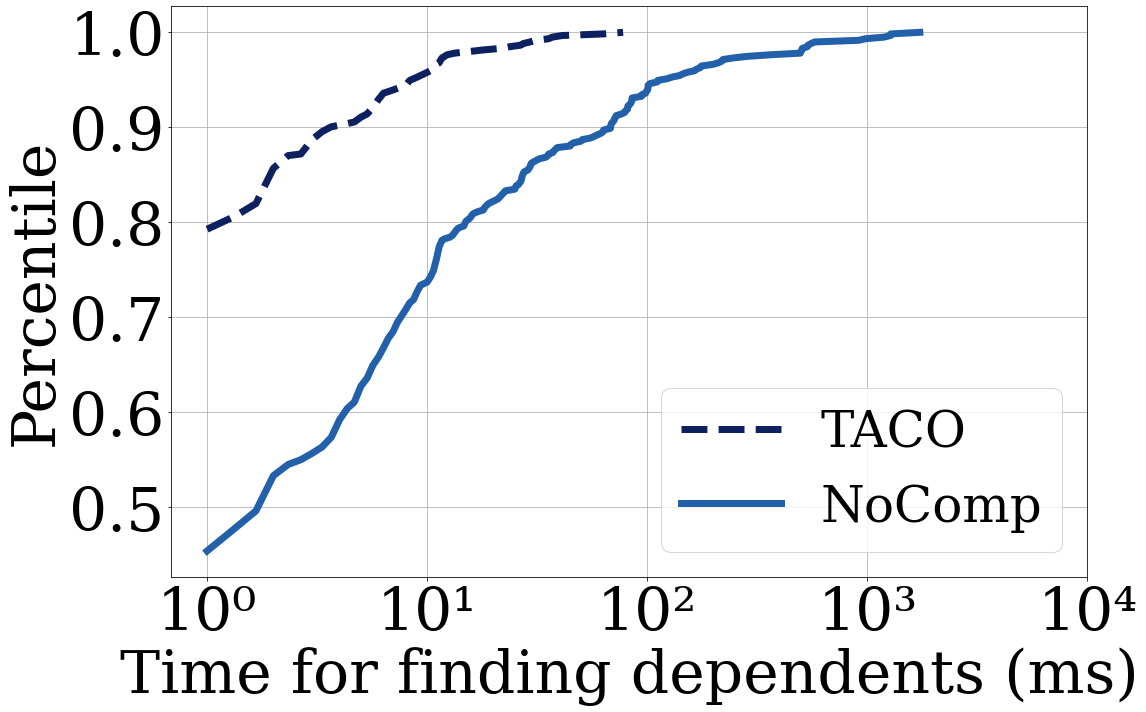

In [37]:
plot_percentile([freq_enron_max_taco_time, freq_enron_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="Time for finding dependents (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=4,
                x_tick_num=4,
               )

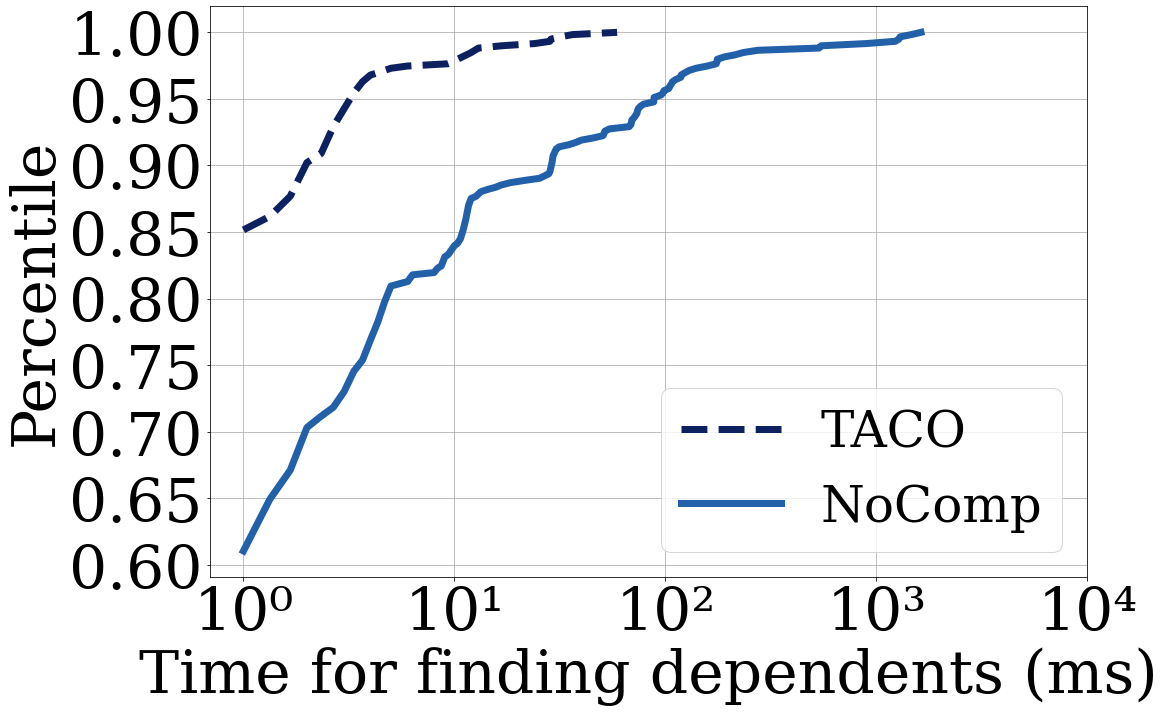

In [38]:
plot_percentile([freq_enron_long_taco_time, freq_enron_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="Time for finding dependents (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=4,
                x_tick_num=4,
               )

In [39]:
freq_github_max_taco_size = get_pdf_df(df_github_merged, 'max_taco_size', True)
freq_github_max_nocomp_size = get_pdf_df(df_github_merged, 'max_nocomp_size', True)
freq_github_max_taco_time = get_pdf_df(df_github_merged, 'max_taco_time', True)
freq_github_max_nocomp_time = get_pdf_df(df_github_merged, 'max_nocomp_time', True)
freq_github_long_taco_size = get_pdf_df(df_github_merged, 'long_taco_size', True)
freq_github_long_nocomp_size = get_pdf_df(df_github_merged, 'long_nocomp_size', True)
freq_github_long_taco_time = get_pdf_df(df_github_merged, 'long_taco_time', True)
freq_github_long_nocomp_time = get_pdf_df(df_github_merged, 'long_nocomp_time', True)

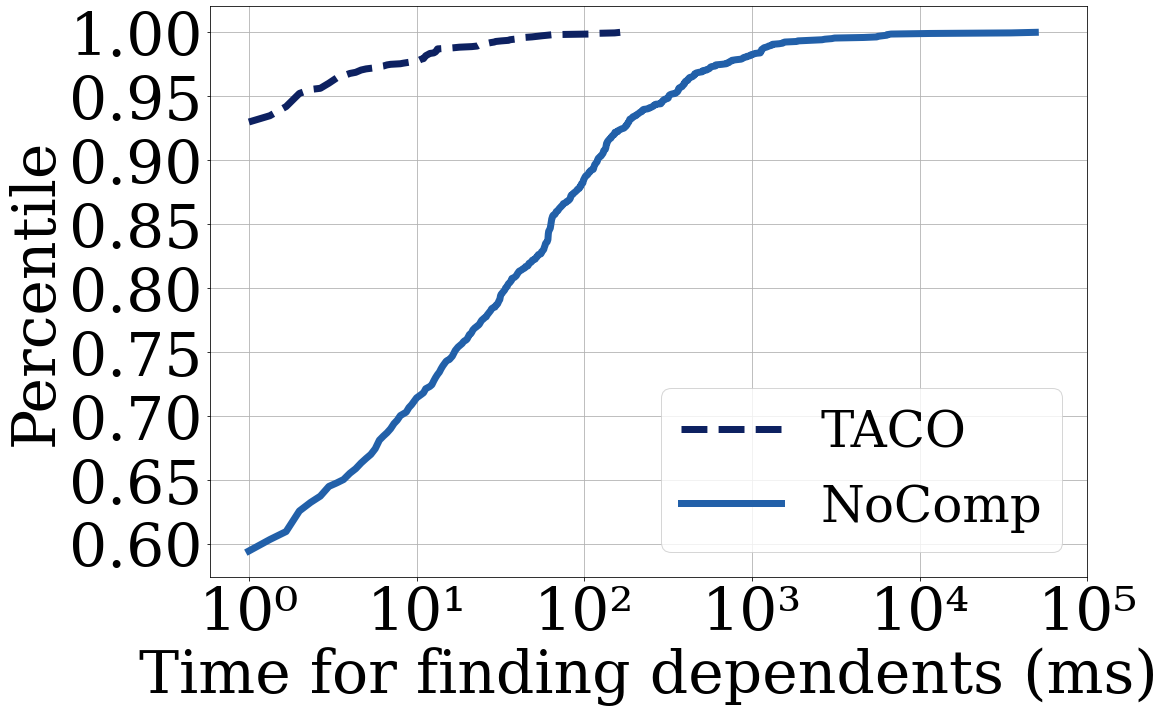

In [40]:
plot_percentile([freq_github_max_taco_time, freq_github_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="Time for finding dependents (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=5,
                x_tick_num=5,
               )

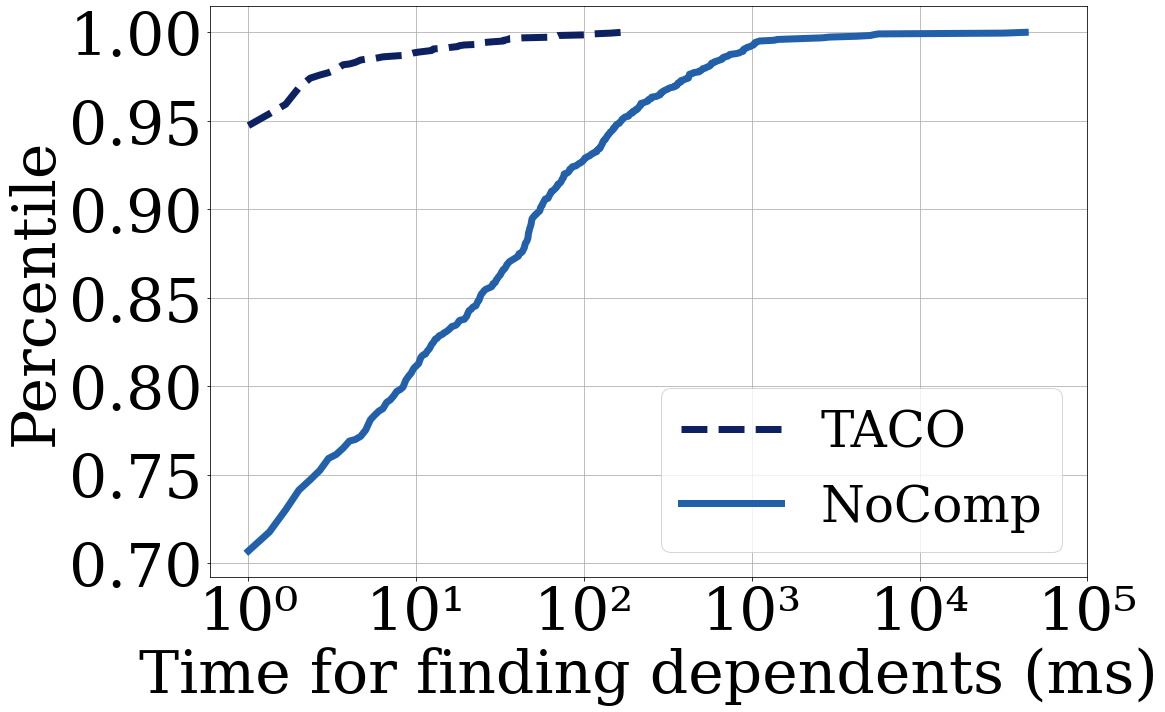

In [41]:
plot_percentile([freq_github_long_taco_time, freq_github_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="Time for finding dependents (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=5,
                x_tick_num=5,
               )

# 4. Modify Formula Graph

In [42]:
def load_modify_results(path, filename):
    filename_list = [filename + "_" + str(i) + ".csv" for i in [1, 2, 3]]
    column_list = ['fileName', 'Max Dep Ref', 'GraphModifyTime']
    df1 = pd.read_csv(path + "/" + filename_list[0])
    df2 = pd.read_csv(path + "/" + filename_list[1])
    df3 = pd.read_csv(path + "/" + filename_list[2])
    df = pd.merge(df1, df2, on=column_list[:2], how="inner")
    df = pd.merge(df, df3, on=column_list[:2], how="inner")
    
    time_ls = []
    cand_col = [x for x in list(df.columns) if "GraphModifyTime" in x]
    for i in range(len(df)):
        ls = []
        for col in cand_col:
            ls.append(df.loc[i, col])
        time_ls.append(np.mean(ls))
    df['GraphModifyTime'] = time_ls
    return df[column_list]

In [43]:
enron_nocomp_modify = load_modify_results(enron_modify, "enron_nocomp_modify")
enron_taco_modify = load_modify_results(enron_modify, "enron_taco_modify")
github_nocomp_modify = load_modify_results(github_modify, "github_nocomp_modify")
github_taco_modify = load_modify_results(github_modify, "github_taco_modify")

In [44]:
freq_enron_taco_modify = get_pdf_df(enron_taco_modify, 'GraphModifyTime', True)
freq_enron_nocomp_modify = get_pdf_df(enron_nocomp_modify, 'GraphModifyTime', True)

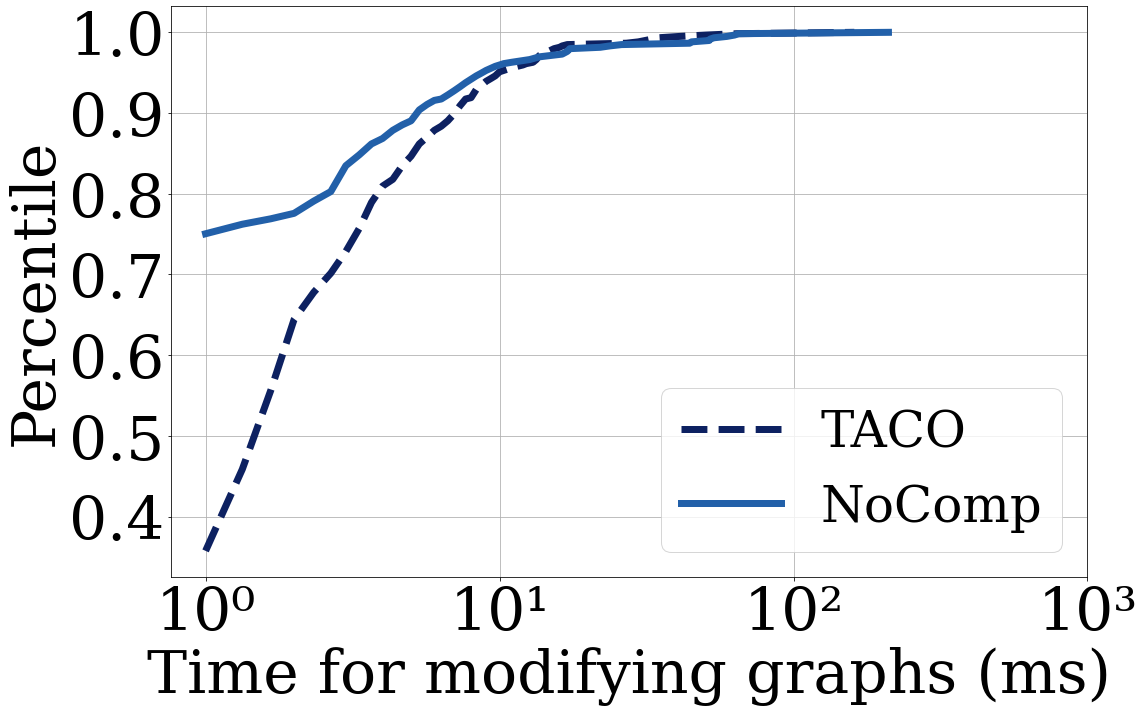

In [45]:
plot_percentile([freq_enron_taco_modify, freq_enron_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="Time for modifying graphs (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=3,
                x_tick_num=3,
               )

In [46]:
freq_github_taco_modify = get_pdf_df(github_taco_modify, 'GraphModifyTime', True)
freq_github_nocomp_modify = get_pdf_df(github_nocomp_modify, 'GraphModifyTime', True)

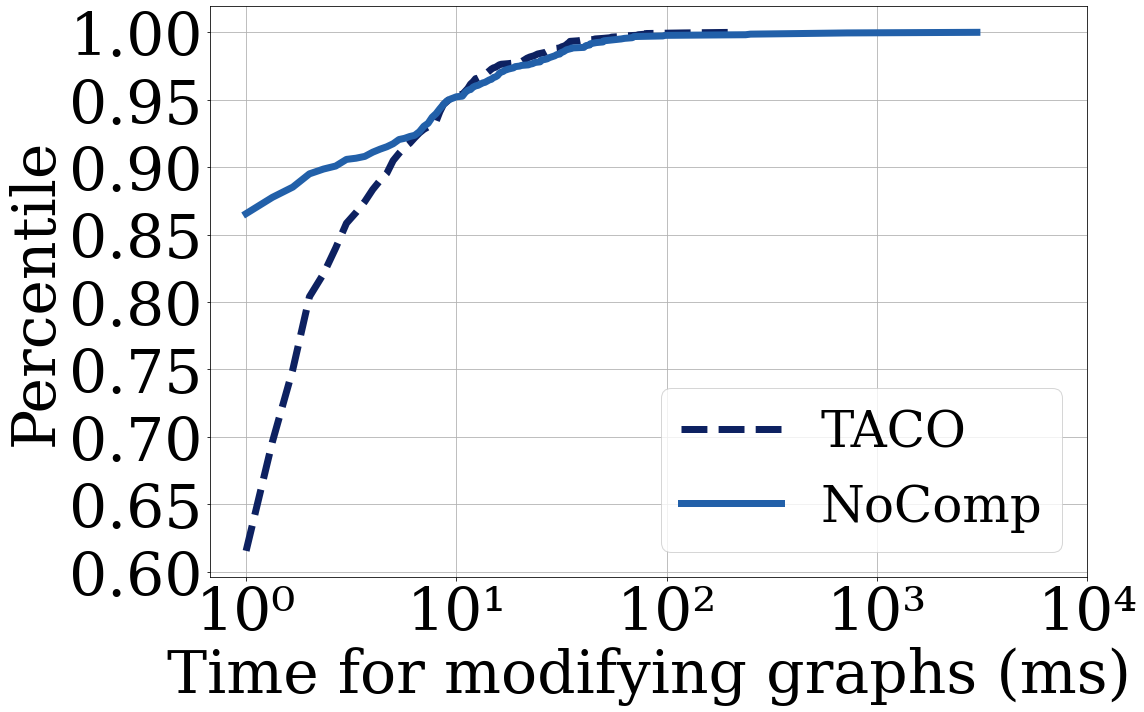

In [47]:
plot_percentile([freq_github_taco_modify, freq_github_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="Time for modifying graphs (ms)",
                ylabel="Percentile",
                x_tick_min=0,
                x_tick_max=4,
                x_tick_num=4,
               )

## 5. Top10 Results

In [48]:
def dnf_process(df):
    column_name = ['LookupTime', 'GraphBuildTime', 'GraphModifyTime']
    column_name = [name for name in column_name if name in df.columns]
    MAX_TIME = 5 * 60 * 1000
    for i in range(len(df)):
        for name in column_name:
            if df.loc[i, name] == -1 or df.loc[i, name] >= MAX_TIME:
                df.loc[i, name] = MAX_TIME
    return df

In [49]:
plot_filename_list = ['max' + str(i+1) for i in range(10)]
plot_filename_list.extend(plot_filename_list)
plot_filename_label = [' ' for i in range(len(plot_filename_list) * 2 + 20)]
length = len(plot_filename_label)
plot_filename_label[length // 3] = "Enron"
plot_filename_label[length - length // 3] = "Github"
plot_filename_label = " ".join(plot_filename_label)

In [50]:
filename_order = []
filename_order += enron_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)['fileName'].tolist()[:10]
filename_order += github_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)['fileName'].tolist()[:10]

### 5.1 Lookup Time

In [51]:
df_enron_merged['max_taco_time'] = df_enron_merged[['max_taco_time', 'long_taco_time']].T.max()
df_github_merged['max_taco_time'] = df_github_merged[['max_taco_time', 'long_taco_time']].T.max()
df_enron_merged['max_nocomp_time'] = df_enron_merged[['max_nocomp_time', 'long_nocomp_time']].T.max()
df_github_merged['max_nocomp_time'] = df_github_merged[['max_nocomp_time', 'long_nocomp_time']].T.max()

In [52]:
antifreeze_enron_lookup = pd.read_excel("./experiment_results/top10_results/enron_antifreeze_lookup_result.xlsx")
antifreeze_github_lookup = pd.read_excel("./experiment_results/top10_results/github_antifreeze_lookup_result.xlsx")

In [53]:
enron_lookup_top10 = df_enron_merged.sort_values(by="max_taco_time", ascending=False)[['fileName', 'max_taco_time', 'max_nocomp_time']]
github_lookup_top10 = df_github_merged.sort_values(by="max_taco_time", ascending=False)[['fileName', 'max_taco_time', 'max_nocomp_time']]

In [54]:
enron_lookup_compare = dnf_process(pd.merge(enron_lookup_top10, antifreeze_enron_lookup, on=["fileName"], how="inner"))
github_lookup_compare = dnf_process(pd.merge(github_lookup_top10, antifreeze_github_lookup, on=["fileName"], how="inner"))

In [55]:
lookup_compare = pd.concat([enron_lookup_compare, github_lookup_compare]).reset_index(drop=True).set_index("fileName")
lookup_compare = lookup_compare.loc[filename_order].reset_index()
lookup_compare

,fileName,max_taco_time,max_nocomp_time,LookupTime
0,benjamin_rogers_000_1_1.pst.39.xls,3.000000,1730.333333,300000
1,vkaminski_001_1_2_1.pst.62.xls,29.333333,273.333333,300000
2,mark_haedicke_000_1_2.pst.31.xls,24.000000,285.333333,300000
3,gstorey_000_1_1.pst.116.xls,0.333333,25.000000,0
4,john_lavorato_000_1_1_1.pst.57.xls,0.000000,17.000000,0
5,phillip_m_love_000_1_1.pst.476.xls,1.000000,71.000000,300000
6,harry_arora_000_1_1.pst.130.xls,0.333333,911.666667,300000
7,jim_schwieger_000_1_1.pst.111.xls,4.000000,8.333333,300000
8,vkaminski_002_1_1_1.pst.12.xls,0.333333,145.000000,300000
9,kam_keiser_000_1_1.pst.16.xls,1.000000,108.000000,300000


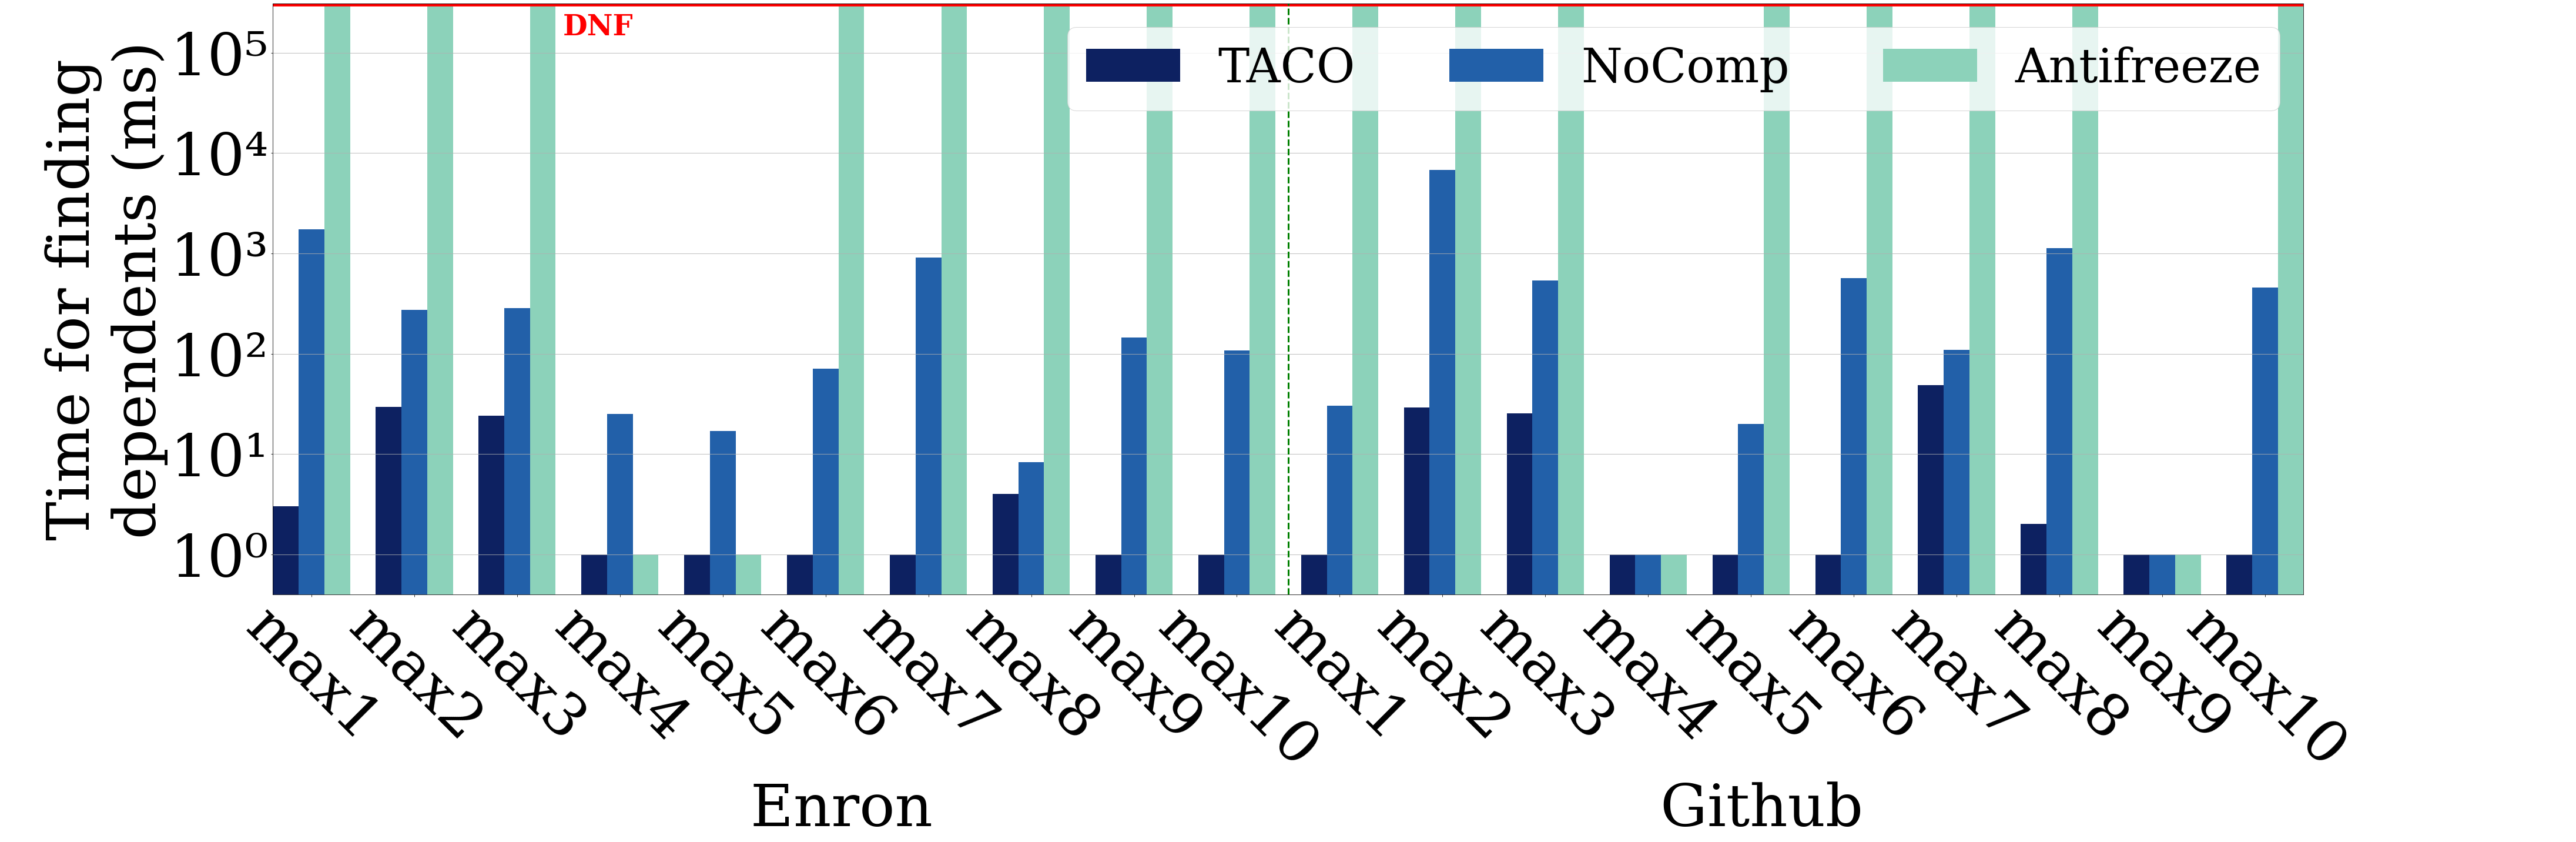

In [56]:
plot_bar_chart(lookup_compare, 
               plot_filename_list,
               label_column_dict={"TACO": "max_taco_time", "NoComp": "max_nocomp_time", "Antifreeze": "LookupTime"},
               xlabel=plot_filename_label,
               ylabel="Time for finding\n dependents (ms)",
               y_tick_min=0,
               y_tick_max=5,
               y_tick_num=5,
               legend_size=80,
               tick_size=100,
               label_size=100,
               fig_size=(55, 20),
              )

### 5.2 Graph Build Time

In [57]:
enron_graph_top10 = enron_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)
github_graph_top10 = github_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)

In [58]:
antifreeze_enron_build = pd.read_excel("./experiment_results/top10_results/enron_antifreeze_graphbuild_result.xlsx")
antifreeze_github_build = pd.read_excel("./experiment_results/top10_results/github_antifreeze_graphbuild_result.xlsx")

In [59]:
enron_graph_compare = dnf_process(pd.merge(enron_graph_top10, antifreeze_enron_build, on=["fileName"], how="inner"))
github_graph_compare = dnf_process(pd.merge(github_graph_top10, antifreeze_github_build, on=["fileName"], how="inner"))

In [60]:
graph_compare = pd.concat([enron_graph_compare, github_graph_compare]).reset_index(drop=True).set_index("fileName")
graph_compare = graph_compare.loc[filename_order].reset_index()
graph_compare

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime,GraphBuildTime
0,benjamin_rogers_000_1_1.pst.39.xls,16625.5,7703.5,300000.000000
1,vkaminski_001_1_2_1.pst.62.xls,14965.5,1451.5,300000.000000
2,mark_haedicke_000_1_2.pst.31.xls,5251.0,1571.0,300000.000000
3,gstorey_000_1_1.pst.116.xls,5006.5,2217.0,213745.333333
4,john_lavorato_000_1_1_1.pst.57.xls,4983.5,1584.0,137516.000000
5,phillip_m_love_000_1_1.pst.476.xls,4559.5,1506.5,300000.000000
6,harry_arora_000_1_1.pst.130.xls,4478.0,2436.0,300000.000000
7,jim_schwieger_000_1_1.pst.111.xls,4029.5,937.5,300000.000000
8,vkaminski_002_1_1_1.pst.12.xls,3886.5,1707.5,300000.000000
9,kam_keiser_000_1_1.pst.16.xls,3771.5,1388.0,300000.000000


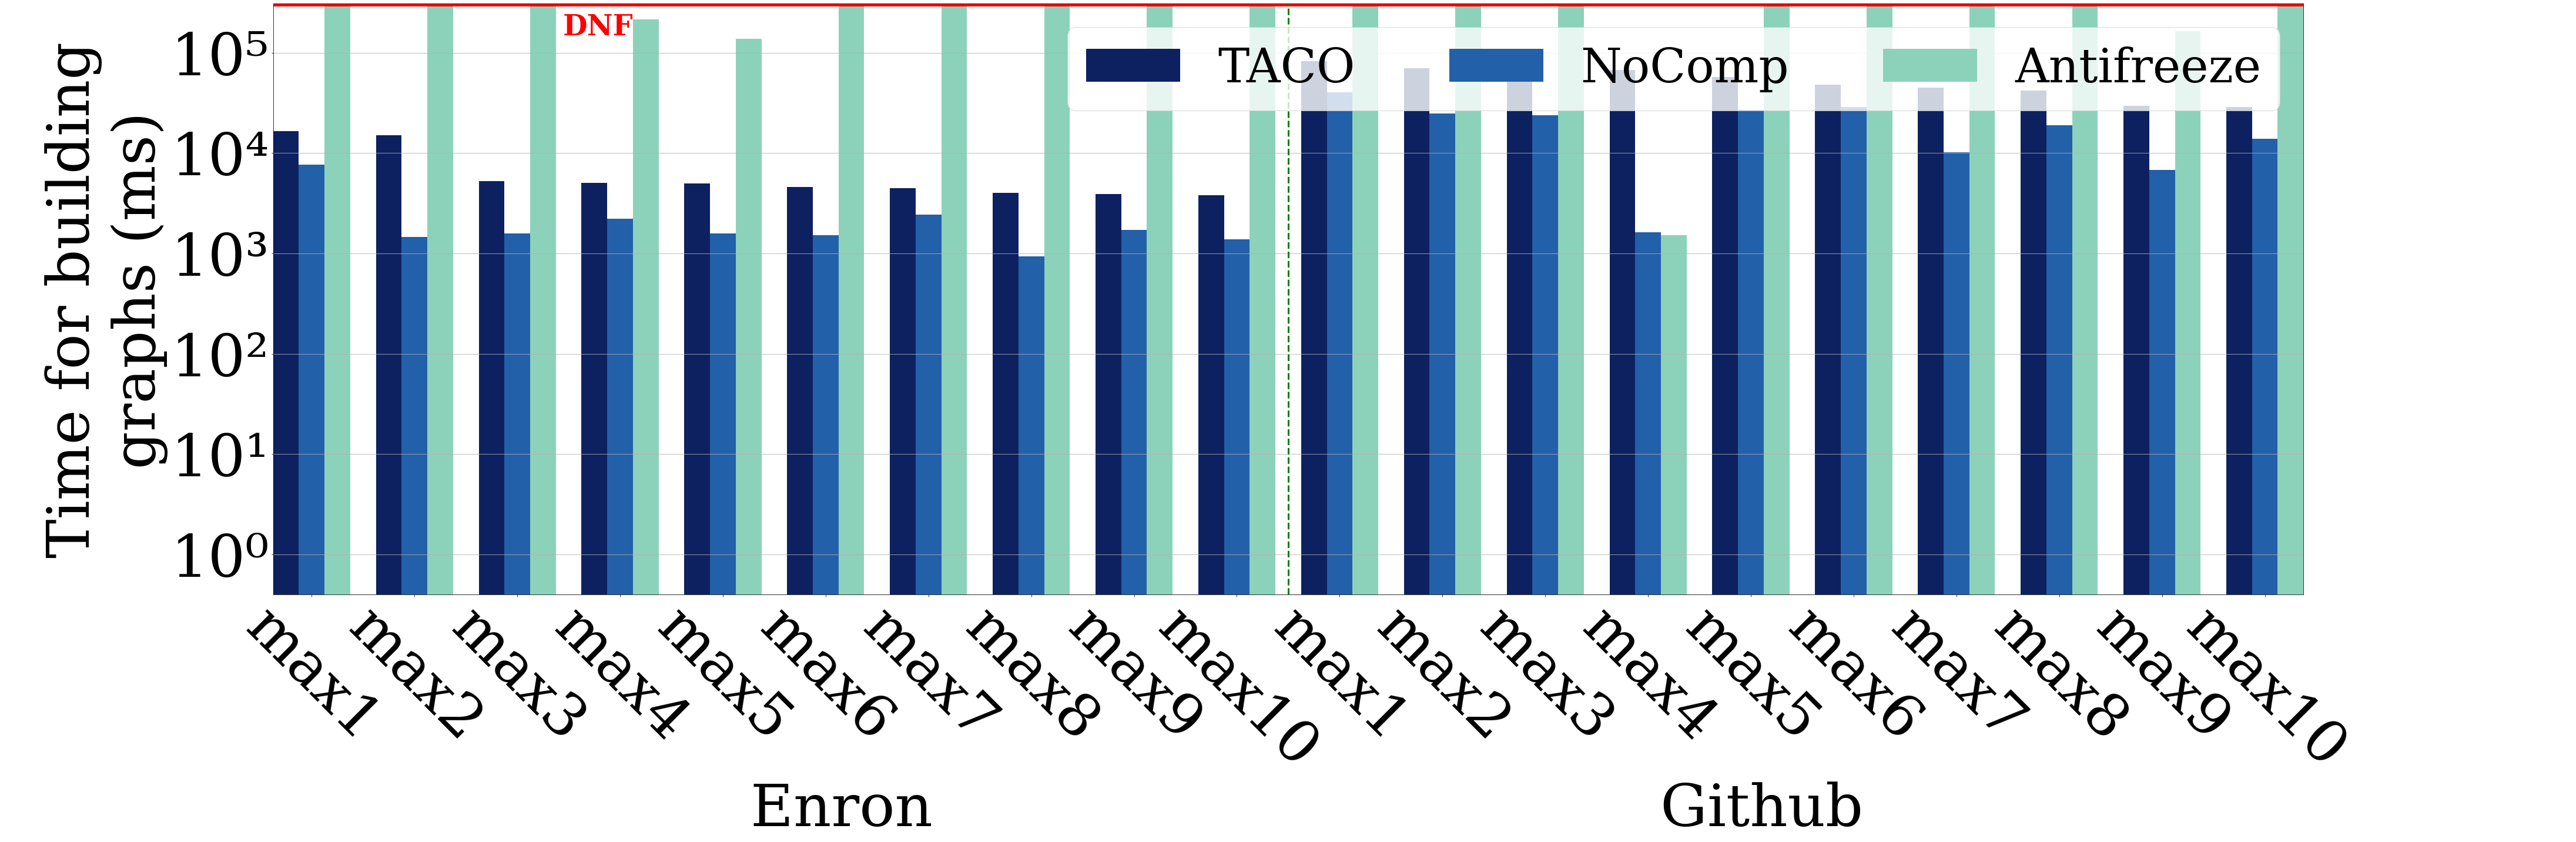

In [61]:
plot_bar_chart(graph_compare, 
               plot_filename_list,
               label_column_dict={"TACO": "TACO_GraphBuildTime", "NoComp": "NoComp_GraphBuildTime", "Antifreeze": "GraphBuildTime"},
               xlabel=plot_filename_label,
               ylabel="Time for building\n graphs (ms)",
               y_tick_min=0,
               y_tick_max=5,
               y_tick_num=5,
               legend_size=80,
               tick_size=100,
               label_size=100,
               fig_size=(55, 20),
              )

### 5.3 Graph Modify Time

In [62]:
enron_taco_modify = enron_taco_modify.rename(columns={"GraphModifyTime": "TACO_GraphModifyTime"})
github_taco_modify = github_taco_modify.rename(columns={"GraphModifyTime": "TACO_GraphModifyTime"})
enron_nocomp_modify = enron_nocomp_modify.rename(columns={"GraphModifyTime": "NoComp_GraphModifyTime"})
github_nocomp_modify = github_nocomp_modify.rename(columns={"GraphModifyTime": "NoComp_GraphModifyTime"})

In [63]:
enron_modify_merged = pd.merge(enron_taco_modify, enron_nocomp_modify, on=["fileName"], how="inner")[['fileName', 'TACO_GraphModifyTime', 'NoComp_GraphModifyTime']]
github_modify_merged = pd.merge(github_taco_modify, github_nocomp_modify, on=["fileName"], how="inner")[['fileName', 'TACO_GraphModifyTime', 'NoComp_GraphModifyTime']]

In [64]:
antifreeze_enron_modify = pd.read_excel("./experiment_results/top10_results/enron_antifreeze_modify_results.xlsx")
antifreeze_github_modify = pd.read_excel("./experiment_results/top10_results/github_antifreeze_modify_results.xlsx")

In [65]:
enron_modify_compare = dnf_process(pd.merge(enron_modify_merged, antifreeze_enron_modify, on=["fileName"], how="inner"))
github_modify_compare = dnf_process(pd.merge(github_modify_merged, antifreeze_github_modify, on=["fileName"], how="inner"))

In [66]:
modify_compare = pd.concat([enron_modify_compare, github_modify_compare]).reset_index(drop=True).set_index('fileName')
modify_compare = modify_compare.loc[filename_order].reset_index()
modify_compare

,fileName,TACO_GraphModifyTime,NoComp_GraphModifyTime,GraphModifyTime
0,benjamin_rogers_000_1_1.pst.39.xls,64.333333,53.666667,300000.000000
1,vkaminski_001_1_2_1.pst.62.xls,161.000000,63.000000,300000.000000
2,mark_haedicke_000_1_2.pst.31.xls,1.666667,0.333333,300000.000000
3,gstorey_000_1_1.pst.116.xls,8.666667,10.333333,19440.333333
4,john_lavorato_000_1_1_1.pst.57.xls,14.666667,13.666667,106880.000000
5,phillip_m_love_000_1_1.pst.476.xls,5.333333,4.000000,300000.000000
6,harry_arora_000_1_1.pst.130.xls,9.666667,210.333333,300000.000000
7,jim_schwieger_000_1_1.pst.111.xls,6.000000,0.000000,300000.000000
8,vkaminski_002_1_1_1.pst.12.xls,50.333333,59.333333,300000.000000
9,kam_keiser_000_1_1.pst.16.xls,4.666667,4.333333,300000.000000


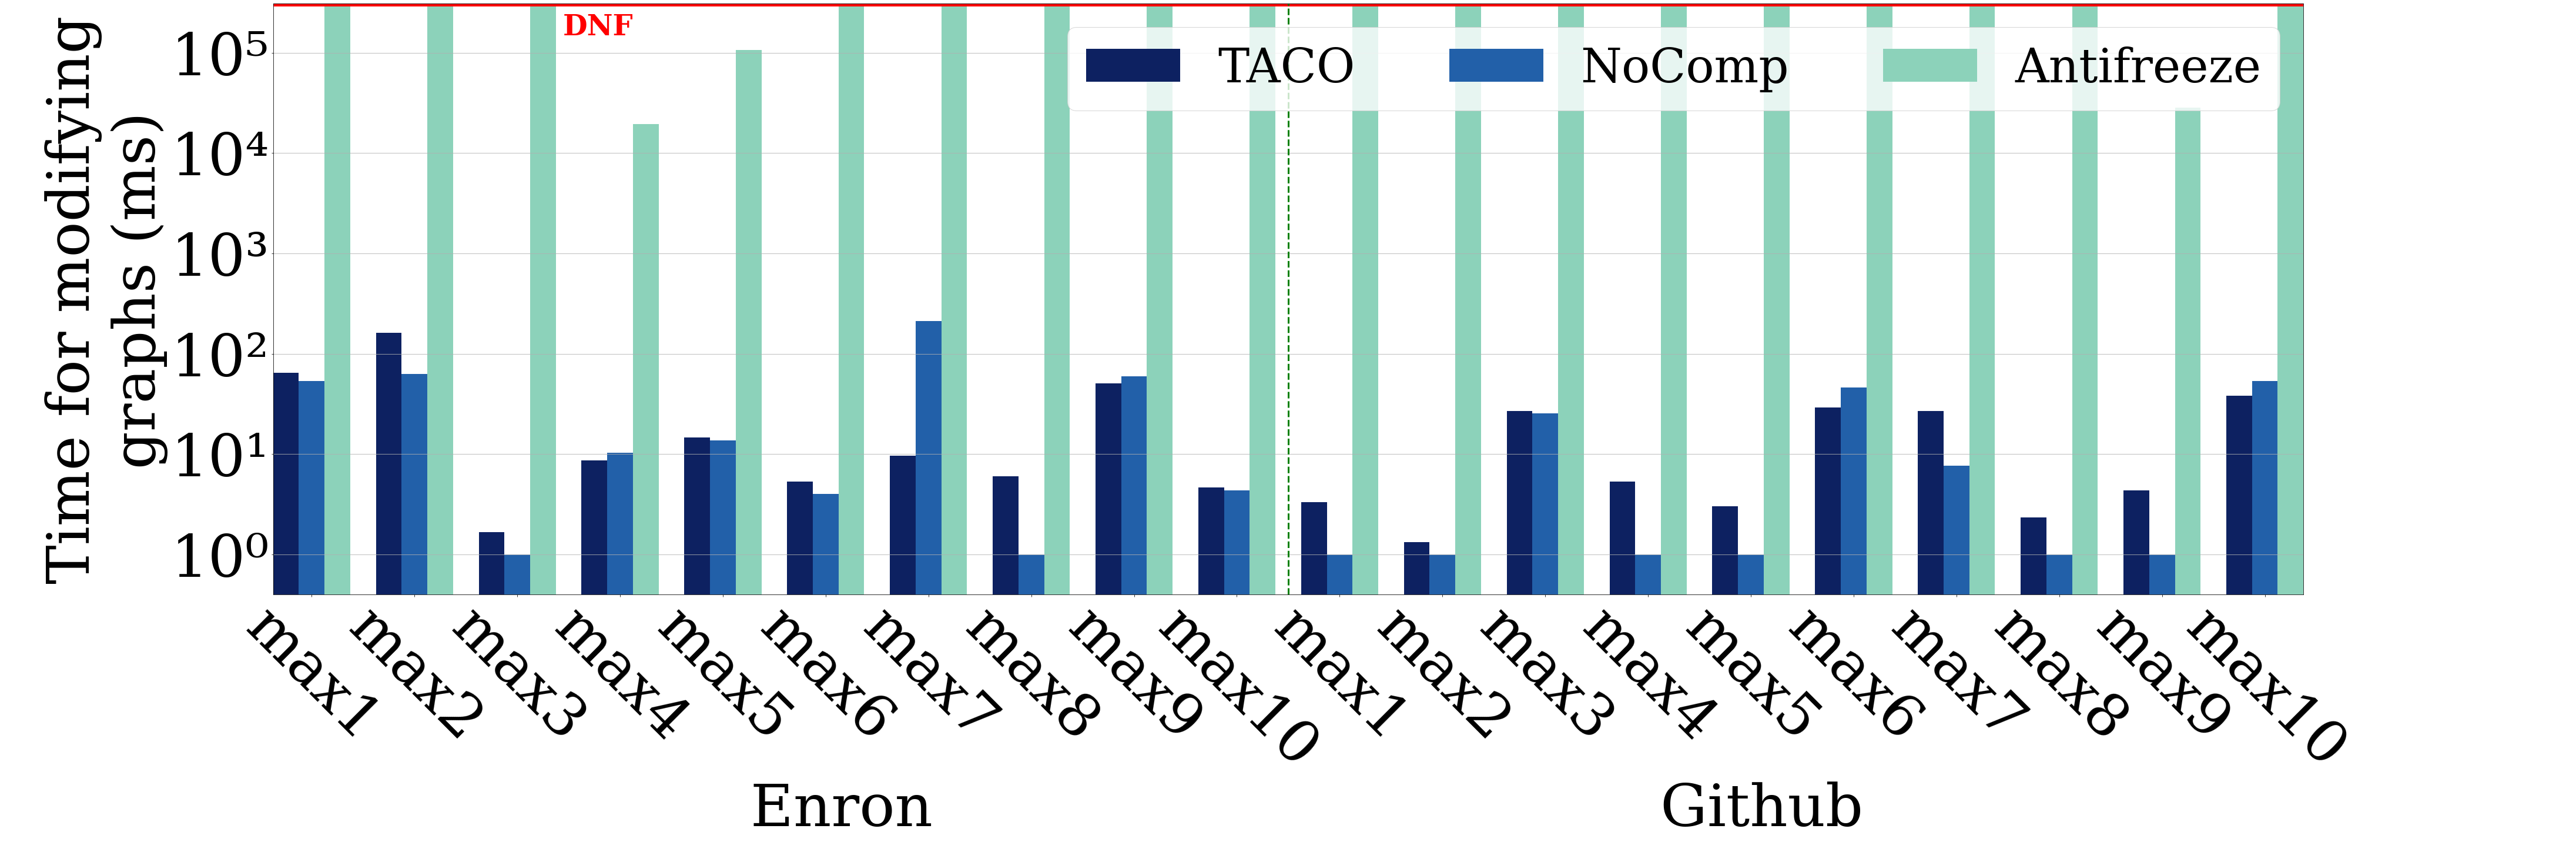

In [67]:
plot_bar_chart(modify_compare, 
               plot_filename_list,
               label_column_dict={"TACO": "TACO_GraphModifyTime", "NoComp": "NoComp_GraphModifyTime", "Antifreeze": "GraphModifyTime"},
               xlabel=plot_filename_label,
               ylabel="Time for modifying\n graphs (ms)",
               y_tick_min=0,
               y_tick_max=5,
               y_tick_num=5,
               legend_size=80,
               tick_size=100,
               label_size=100,
               fig_size=(55, 20),
              )